In [1]:
import polars as pl

In [2]:
pitching = pl.read_csv("./data/lahman_1871-2024_csv/pitching.csv")
pitching.head()

playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""aardsda01""",2004,1,"""SFN""","""NL""",1,0,11,0,0,0,0,32,20,8,1,10,5,0.417,6.75,0,0,2,0,61,5,8,0,1,1
"""aardsda01""",2006,1,"""CHN""","""NL""",3,0,45,0,0,0,0,159,41,24,9,28,49,0.214,4.08,0,1,1,0,225,9,25,1,3,2
"""aardsda01""",2007,1,"""CHA""","""AL""",2,1,25,0,0,0,0,97,39,23,4,17,36,0.3,6.4,3,2,1,0,151,7,24,2,1,1
"""aardsda01""",2008,1,"""BOS""","""AL""",4,2,47,0,0,0,0,146,49,30,4,35,49,0.268,5.55,2,3,5,0,228,7,32,3,2,4
"""aardsda01""",2009,1,"""SEA""","""AL""",3,6,73,0,0,0,38,214,49,20,4,34,80,0.19,2.52,3,2,0,0,296,53,23,2,1,2


In [3]:
league_ERA = (
    pitching
    .filter(pl.col("yearID") >= 1946)
    .group_by(["yearID", "lgID"])
    .agg([
        pl.col("ER").sum().alias("total_ER"),
        pl.col("IPouts").sum().alias("total_IPouts")
    ])
    .with_columns(
        ((9 * pl.col("total_ER")) / (pl.col("total_IPouts") * 3)).alias("league_ERA")
    )
)

print("Current league_ERA structure:")
print(league_ERA.head())
print(f"Columns: {league_ERA.columns}")


Current league_ERA structure:
shape: (5, 5)
┌────────┬──────┬──────────┬──────────────┬────────────┐
│ yearID ┆ lgID ┆ total_ER ┆ total_IPouts ┆ league_ERA │
│ ---    ┆ ---  ┆ ---      ┆ ---          ┆ ---        │
│ i64    ┆ str  ┆ i64      ┆ i64          ┆ f64        │
╞════════╪══════╪══════════╪══════════════╪════════════╡
│ 2012   ┆ AL   ┆ 9212     ┆ 60855        ┆ 0.454129   │
│ 1992   ┆ NL   ┆ 6823     ┆ 52502        ┆ 0.389871   │
│ 1980   ┆ NL   ┆ 7029     ┆ 52589        ┆ 0.400977   │
│ 1958   ┆ AL   ┆ 4617     ┆ 33072        ┆ 0.418813   │
│ 2015   ┆ NL   ┆ 9436     ┆ 65140        ┆ 0.434572   │
└────────┴──────┴──────────┴──────────────┴────────────┘
Columns: ['yearID', 'lgID', 'total_ER', 'total_IPouts', 'league_ERA']


In [4]:
def assign_dh_state(year, league):
    if year < 1973:
        return "No DH (Both Leagues)"
    elif year >= 2022:
        return "Universal DH"
    elif league == "AL":
        return "AL with DH"
    elif league == "NL":
        return "NL without DH"
    else:
        return "Unknown"

league_ERA_with_DH = league_ERA.with_columns(
    pl.struct(["yearID", "lgID"]).map_elements(
        lambda row: assign_dh_state(row["yearID"], row["lgID"])
    ).alias("DH_state")
)

print("\nLeague ERA with DH states:")
print(league_ERA_with_DH.head(10))

print("\nUnique DH states:")
print(league_ERA_with_DH.select("DH_state").unique().sort("DH_state"))
league_ERA_with_DH.write_csv("./league_ERA_analysis.csv")
print("\nData saved to ./league_ERA_analysis.csv")
print("\nSample of saved data (sorted by year and league):")
print(league_ERA_with_DH.sort(["yearID", "lgID"]).head(15))

league_ERA.head()


League ERA with DH states:
shape: (10, 6)
┌────────┬──────┬──────────┬──────────────┬────────────┬──────────────────────┐
│ yearID ┆ lgID ┆ total_ER ┆ total_IPouts ┆ league_ERA ┆ DH_state             │
│ ---    ┆ ---  ┆ ---      ┆ ---          ┆ ---        ┆ ---                  │
│ i64    ┆ str  ┆ i64      ┆ i64          ┆ f64        ┆ str                  │
╞════════╪══════╪══════════╪══════════════╪════════════╪══════════════════════╡
│ 2012   ┆ AL   ┆ 9212     ┆ 60855        ┆ 0.454129   ┆ AL with DH           │
│ 1992   ┆ NL   ┆ 6823     ┆ 52502        ┆ 0.389871   ┆ NL without DH        │
│ 1980   ┆ NL   ┆ 7029     ┆ 52589        ┆ 0.400977   ┆ NL without DH        │
│ 1958   ┆ AL   ┆ 4617     ┆ 33072        ┆ 0.418813   ┆ No DH (Both Leagues) │
│ 2015   ┆ NL   ┆ 9436     ┆ 65140        ┆ 0.434572   ┆ NL without DH        │
│ 1989   ┆ NL   ┆ 6823     ┆ 52602        ┆ 0.38913    ┆ NL without DH        │
│ 1995   ┆ AL   ┆ 9428     ┆ 53928        ┆ 0.524477   ┆ AL with DH          

C:\Users\ke9712wb\AppData\Local\Temp\ipykernel_24564\2099630442.py:13: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  league_ERA_with_DH = league_ERA.with_columns(


yearID,lgID,total_ER,total_IPouts,league_ERA
i64,str,i64,i64,f64
2012,"""AL""",9212,60855,0.454129
1992,"""NL""",6823,52502,0.389871
1980,"""NL""",7029,52589,0.400977
1958,"""AL""",4617,33072,0.418813
2015,"""NL""",9436,65140,0.434572


In [5]:
years = league_ERA.select("yearID").unique().to_series().to_list()
leagues = league_ERA.select("lgID").unique().to_series().to_list()

all_years_leagues = (
    pl.DataFrame({"yearID": years})
    .join(pl.DataFrame({"lgID": leagues}), how="cross")
)

era_full = (
    all_years_leagues
    .join(league_ERA, on=["yearID", "lgID"], how="left")
)

era_wide = (
    era_full
    .pivot(index="yearID", columns="lgID", values="league_ERA").sort("yearID")  # Changed from "ERA" to "league_ERA"
)

era_wide = era_wide.with_columns((pl.col("AL") - pl.col("NL")).alias("AL-NL"))

era_long = (
    era_wide
    .melt(id_vars="yearID", value_vars=["AL", "NL", "AL-NL"],
          variable_name="league", value_name="ERA")  # This is fine - you're renaming the melted values to "ERA"
    .sort(["yearID", "league"])
)

era_mean = float(era_long["ERA"].mean())
era_ymax = float(era_long["ERA"].max())

print(era_long.head(10))

shape: (10, 3)
┌────────┬────────┬───────────┐
│ yearID ┆ league ┆ ERA       │
│ ---    ┆ ---    ┆ ---       │
│ i64    ┆ str    ┆ f64       │
╞════════╪════════╪═══════════╡
│ 1946   ┆ AL     ┆ 0.389261  │
│ 1946   ┆ AL-NL  ┆ 0.010178  │
│ 1946   ┆ NL     ┆ 0.379082  │
│ 1947   ┆ AL     ┆ 0.411701  │
│ 1947   ┆ AL-NL  ┆ -0.040186 │
│ 1947   ┆ NL     ┆ 0.451887  │
│ 1948   ┆ AL     ┆ 0.475842  │
│ 1948   ┆ AL-NL  ┆ 0.036435  │
│ 1948   ┆ NL     ┆ 0.439407  │
│ 1949   ┆ AL     ┆ 0.466411  │
└────────┴────────┴───────────┘


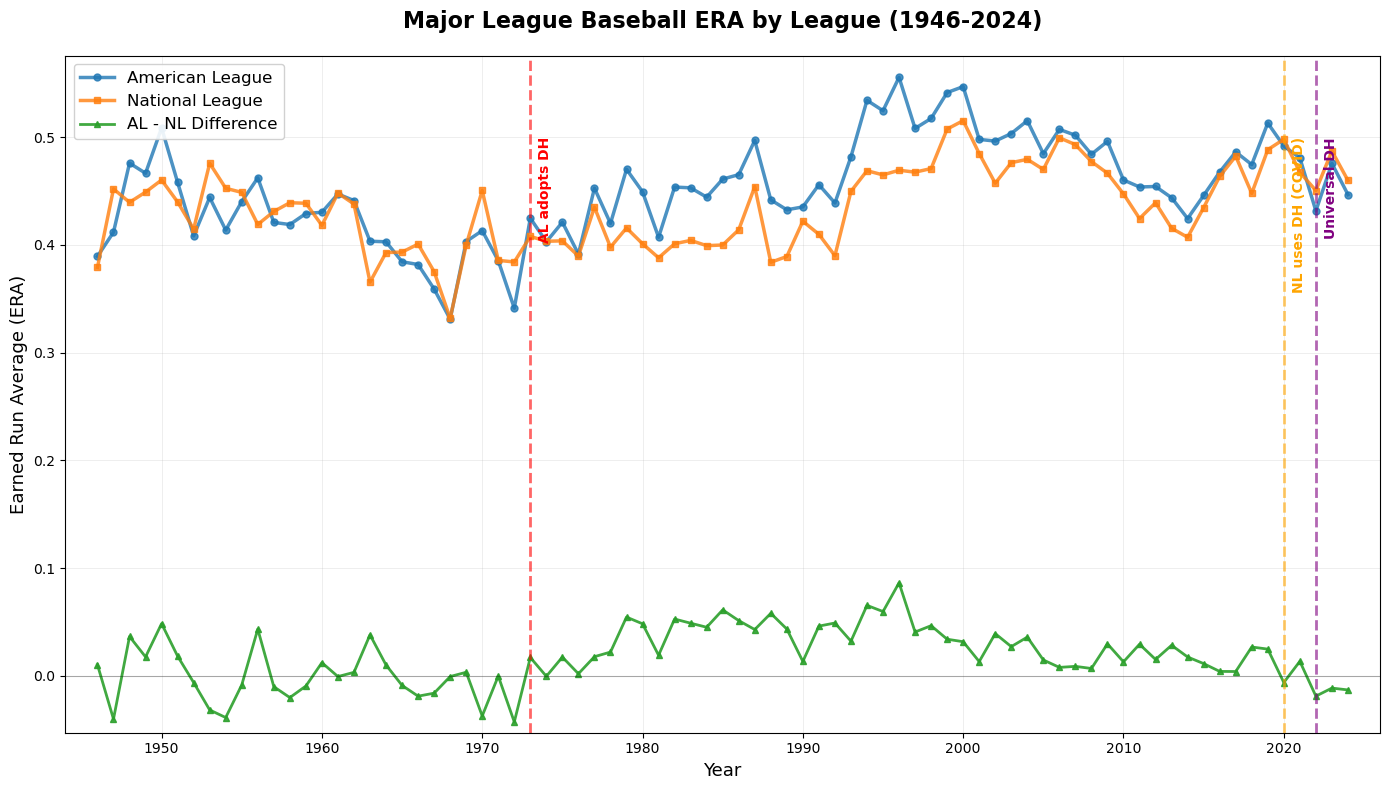

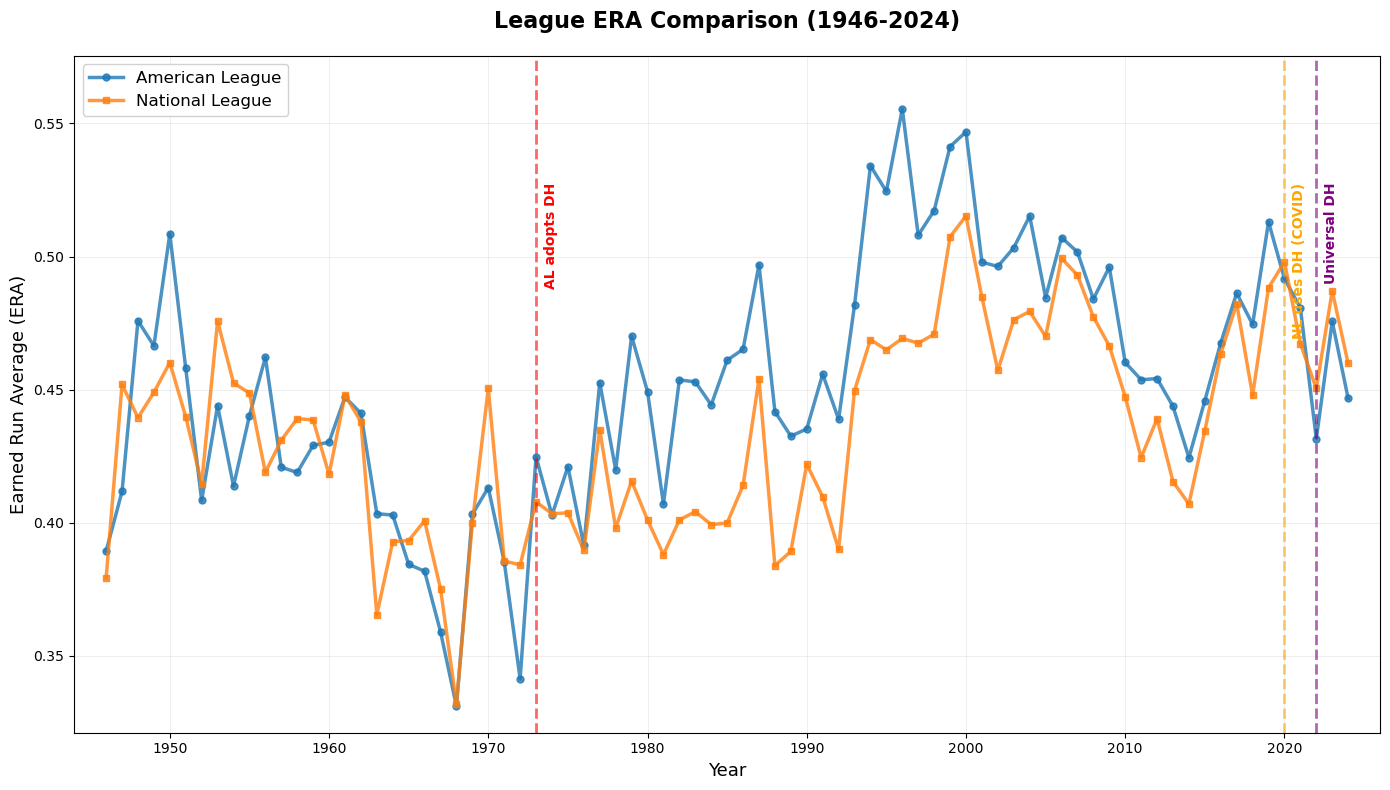

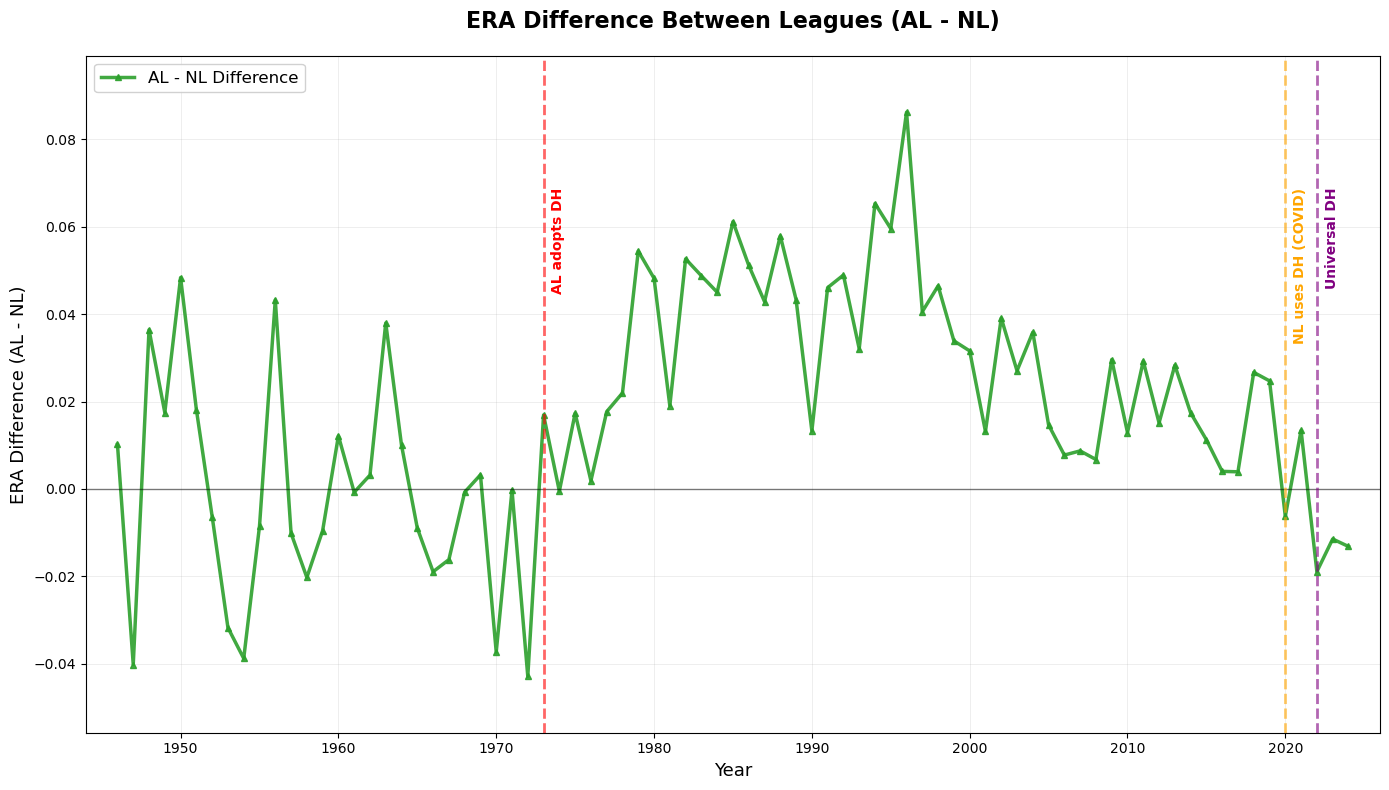


SUMMARY STATISTICS (Pure Polars)
shape: (3, 6)
┌────────┬──────────┬─────────┬─────────┬─────────┬────────────┐
│ league ┆ Mean ERA ┆ Std Dev ┆ Min ERA ┆ Max ERA ┆ Median ERA │
│ ---    ┆ ---      ┆ ---     ┆ ---     ┆ ---     ┆ ---        │
│ str    ┆ f64      ┆ f64     ┆ f64     ┆ f64     ┆ f64        │
╞════════╪══════════╪═════════╪═════════╪═════════╪════════════╡
│ AL     ┆ 0.4523   ┆ 0.0463  ┆ 0.331   ┆ 0.5555  ┆ 0.4526     │
│ AL-NL  ┆ 0.0174   ┆ 0.0271  ┆ -0.0429 ┆ 0.0862  ┆ 0.0169     │
│ NL     ┆ 0.4349   ┆ 0.038   ┆ 0.3317  ┆ 0.5153  ┆ 0.439      │
└────────┴──────────┴─────────┴─────────┴─────────┴────────────┘

ERA BY DH PERIOD (Pure Polars)

Pre-DH (1946-1972):
shape: (2, 2)
┌────────┬──────────┐
│ league ┆ Mean ERA │
│ ---    ┆ ---      │
│ str    ┆ f64      │
╞════════╪══════════╡
│ AL     ┆ 0.4174   │
│ NL     ┆ 0.4193   │
└────────┴──────────┘

Partial DH (1973-2021):
shape: (2, 2)
┌────────┬──────────┐
│ league ┆ Mean ERA │
│ ---    ┆ ---      │
│ str    ┆ f64     

In [14]:
import matplotlib.pyplot as plt

al_data = era_long.filter(pl.col('league') == 'AL').sort('yearID')
nl_data = era_long.filter(pl.col('league') == 'NL').sort('yearID')
diff_data = era_long.filter(pl.col('league') == 'AL-NL').sort('yearID')
years = al_data.select('yearID').to_series().to_list()
al_era = al_data.select('ERA').to_series().to_list()
nl_era = nl_data.select('ERA').to_series().to_list()
diff_era = diff_data.select('ERA').to_series().to_list()
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(years, al_era, 'o-', label='American League', 
        color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax.plot(years, nl_era, 's-', label='National League', 
        color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)
ax.plot(years, diff_era, '^-', label='AL - NL Difference', 
        color='#2ca02c', linewidth=2, markersize=4, alpha=0.9)

# Add vertical lines for DH rule changes
dh_events = [
    (1973, 'AL adopts DH'),
    (2020, 'NL uses DH (COVID)'),
    (2022, 'Universal DH')
]

colors = ['red', 'orange', 'purple']
for i, (year, label) in enumerate(dh_events):
    ax.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    
    # Add text labels for the events
    ax.text(year + 0.5, max(al_era + nl_era) * 0.9, label, 
            rotation=90, verticalalignment='top', 
            horizontalalignment='left', fontsize=10, 
            color=colors[i], weight='bold')

# Customize the plot
ax.set_title('Major League Baseball ERA by League (1946-2024)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Earned Run Average (ERA)', fontsize=13)

# Add a horizontal line at y=0 for the difference plot
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)

# Customize legend
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)

# Add grid
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set axis limits with some padding
ax.set_xlim(min(years) - 2, max(years) + 2)
era_min = min(min(al_era), min(nl_era), min(diff_era))
era_max = max(max(al_era), max(nl_era), max(diff_era))
ax.set_ylim(era_min - 0.01, era_max + 0.02)

# Improve layout
plt.tight_layout()
plt.show()

# ADDITIONAL GRAPHS: Two separate plots for better scale comparison

# Graph 1: AL and NL ERA only (without difference)
fig1, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(years, al_era, 'o-', label='American League', 
         color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax1.plot(years, nl_era, 's-', label='National League', 
         color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)

# Add vertical lines for DH rule changes
for i, (year, label) in enumerate(dh_events):
    ax1.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    
    # Add text labels for the events
    ax1.text(year + 0.5, max(al_era + nl_era) * 0.95, label, 
             rotation=90, verticalalignment='top', 
             horizontalalignment='left', fontsize=10, 
             color=colors[i], weight='bold')

ax1.set_title('League ERA Comparison (1946-2024)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=13)
ax1.set_ylabel('Earned Run Average (ERA)', fontsize=13)
ax1.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set axis limits optimized for ERA values only
era_min_leagues = min(min(al_era), min(nl_era))
era_max_leagues = max(max(al_era), max(nl_era))
ax1.set_xlim(min(years) - 2, max(years) + 2)
ax1.set_ylim(era_min_leagues - 0.01, era_max_leagues + 0.02)

plt.tight_layout()
plt.show()

# Graph 2: AL-NL Difference only (with proper scale)
fig2, ax2 = plt.subplots(figsize=(14, 8))

ax2.plot(years, diff_era, '^-', label='AL - NL Difference', 
         color='#2ca02c', linewidth=2.5, markersize=5, alpha=0.9)

# Add horizontal line at y=0 for reference
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Add vertical lines for DH rule changes
for i, (year, label) in enumerate(dh_events):
    ax2.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    
    # Position labels relative to the difference scale
    label_height = max(diff_era) * 0.8 if max(diff_era) > 0 else min(diff_era) * 0.8
    ax2.text(year + 0.5, label_height, label, 
             rotation=90, verticalalignment='top' if max(diff_era) > 0 else 'bottom', 
             horizontalalignment='left', fontsize=10, 
             color=colors[i], weight='bold')

ax2.set_title('ERA Difference Between Leagues (AL - NL)', 
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Year', fontsize=13)
ax2.set_ylabel('ERA Difference (AL - NL)', fontsize=13)
ax2.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set axis limits optimized for difference values
diff_min = min(diff_era)
diff_max = max(diff_era)
padding = (diff_max - diff_min) * 0.1
ax2.set_xlim(min(years) - 2, max(years) + 2)
ax2.set_ylim(diff_min - padding, diff_max + padding)

plt.tight_layout()
plt.show()

# Print summary statistics using pure Polars
print("\n" + "="*60)
print("SUMMARY STATISTICS (Pure Polars)")
print("="*60)

summary_stats = (
    era_long
    .group_by('league')
    .agg([
        pl.col('ERA').mean().round(4).alias('Mean ERA'),
        pl.col('ERA').std().round(4).alias('Std Dev'),
        pl.col('ERA').min().round(4).alias('Min ERA'),
        pl.col('ERA').max().round(4).alias('Max ERA'),
        pl.col('ERA').median().round(4).alias('Median ERA')
    ])
    .sort('league')
)

print(summary_stats)

# Additional analysis: ERA trends by DH periods using Polars
print("\n" + "="*60)
print("ERA BY DH PERIOD (Pure Polars)")
print("="*60)

# Define periods
pre_dh = era_long.filter((pl.col('yearID') < 1973) & (pl.col('league') != 'AL-NL'))
partial_dh = era_long.filter((pl.col('yearID') >= 1973) & (pl.col('yearID') < 2022) & (pl.col('league') != 'AL-NL'))
universal_dh = era_long.filter((pl.col('yearID') >= 2022) & (pl.col('league') != 'AL-NL'))

periods = [
    ("Pre-DH (1946-1972)", pre_dh),
    ("Partial DH (1973-2021)", partial_dh), 
    ("Universal DH (2022+)", universal_dh)
]

for period_name, data in periods:
    if data.height > 0:  # Check if data exists
        period_stats = (
            data
            .group_by('league')
            .agg(pl.col('ERA').mean().round(4).alias('Mean ERA'))
            .sort('league')
        )
        print(f"\n{period_name}:")
        print(period_stats)
    else:
        print(f"\n{period_name}: No data available")

League Slugging Percentage structure:
shape: (5, 5)
┌────────┬──────┬─────────────┬──────────┬────────────┐
│ yearID ┆ lgID ┆ total_bases ┆ total_AB ┆ league_SLG │
│ ---    ┆ ---  ┆ ---         ┆ ---      ┆ ---        │
│ i64    ┆ str  ┆ i64         ┆ i64      ┆ f64        │
╞════════╪══════╪═════════════╪══════════╪════════════╡
│ 1998   ┆ NL   ┆ 36383       ┆ 88700    ┆ 0.41018    │
│ 1997   ┆ AL   ┆ 33495       ┆ 78235    ┆ 0.428133   │
│ 1959   ┆ AL   ┆ 16118       ┆ 41964    ┆ 0.384091   │
│ 2002   ┆ NL   ┆ 35996       ┆ 87794    ┆ 0.410005   │
│ 1977   ┆ NL   ┆ 26443       ┆ 66700    ┆ 0.396447   │
└────────┴──────┴─────────────┴──────────┴────────────┘

Sluggging percentage data shape: (237, 3)
shape: (10, 3)
┌────────┬────────┬───────────┐
│ yearID ┆ league ┆ SLG       │
│ ---    ┆ ---    ┆ ---       │
│ i64    ┆ str    ┆ f64       │
╞════════╪════════╪═══════════╡
│ 1946   ┆ AL     ┆ 0.364142  │
│ 1946   ┆ AL-NL  ┆ 0.008652  │
│ 1946   ┆ NL     ┆ 0.35549   │
│ 1947   ┆ AL     

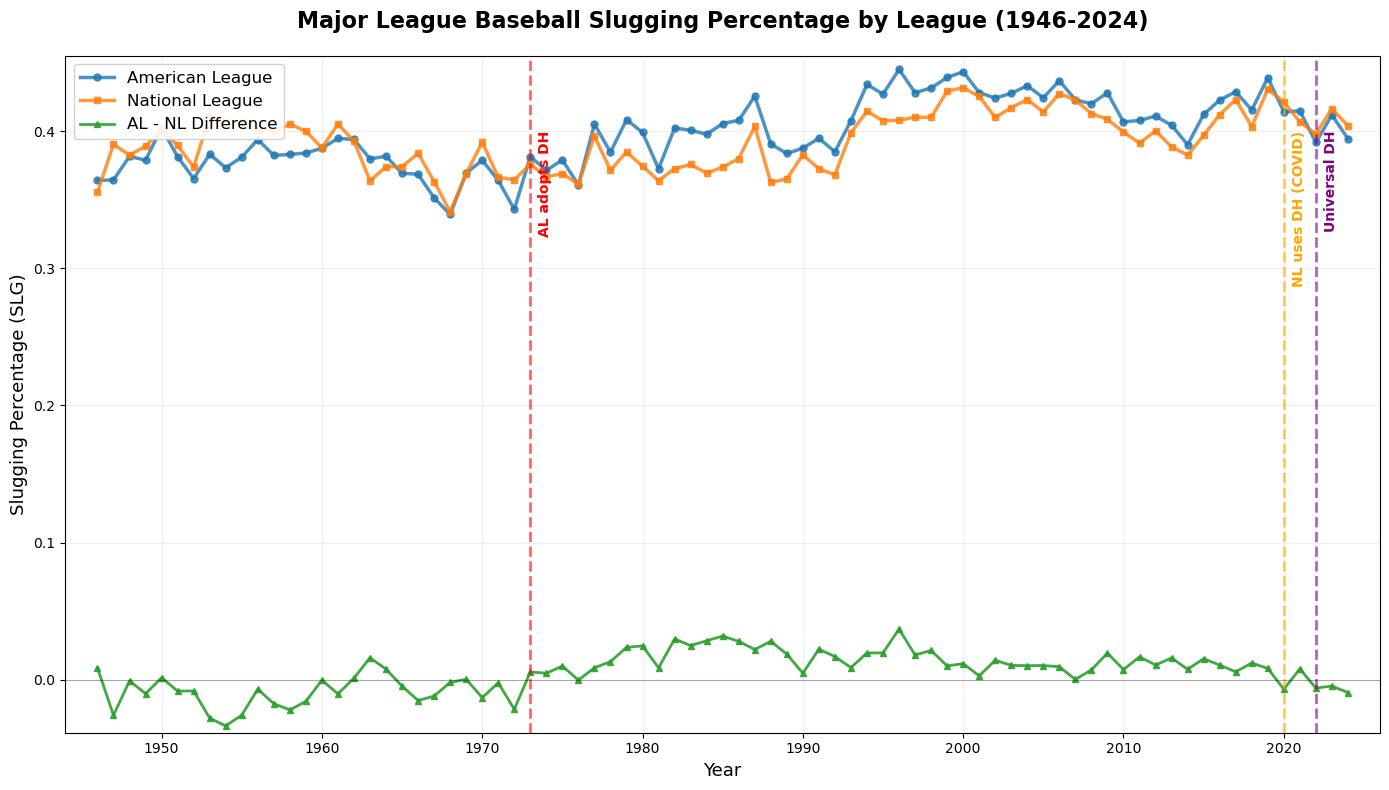


GRAPH 2: League Comparison (AL vs NL Only)


AttributeError: Line2D.set() got an unexpected keyword argument 'linetype'

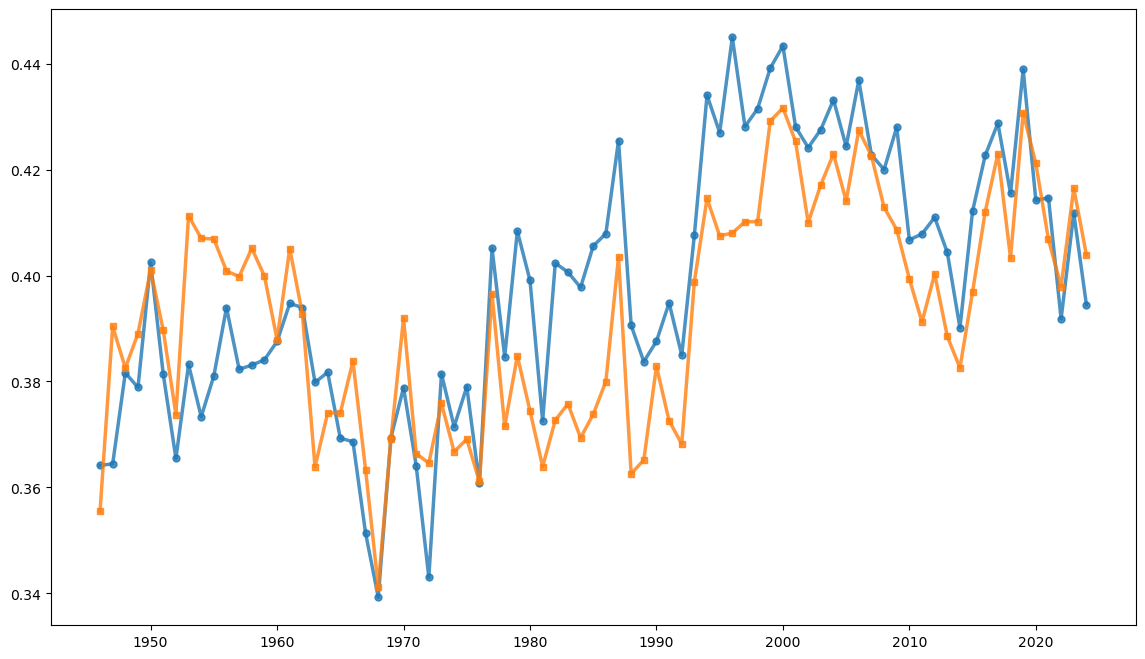

In [16]:
# Load batting data and calculate league-wide slugging percentage
batting = pl.read_csv("./data/lahman_1871-2024_csv/batting.csv")

# Calculate league slugging percentage (SLG = Total Bases / At Bats)
league_SLG = (
    batting
    .filter(pl.col("yearID") >= 1946)
    .group_by(["yearID", "lgID"])
    .agg([
        pl.col("H").sum().alias("total_H"),      # Singles + 2B + 3B + HR
        pl.col("2B").sum().alias("total_2B"),    # Doubles  
        pl.col("3B").sum().alias("total_3B"),    # Triples
        pl.col("HR").sum().alias("total_HR"),    # Home runs
        pl.col("AB").sum().alias("total_AB")     # At bats
    ])
    .with_columns([
        # Calculate total bases: H + 2B + 3B + 2*HR (since H includes all hits, we add extra bases)
        (pl.col("total_H") + pl.col("total_2B") + 2*pl.col("total_3B") + 3*pl.col("total_HR")).alias("total_bases"),
        # Slugging percentage = total bases / at bats
        ((pl.col("total_H") + pl.col("total_2B") + 2*pl.col("total_3B") + 3*pl.col("total_HR")) / pl.col("total_AB")).alias("league_SLG")
    ])
    .select(["yearID", "lgID", "total_bases", "total_AB", "league_SLG"])
)

print("League Slugging Percentage structure:")
print(league_SLG.head())

# Create wide format and calculate difference
years = league_SLG.select("yearID").unique().to_series().to_list()
leagues = league_SLG.select("lgID").unique().to_series().to_list()

all_years_leagues = (
    pl.DataFrame({"yearID": years})
    .join(pl.DataFrame({"lgID": leagues}), how="cross")
)

slg_full = (
    all_years_leagues
    .join(league_SLG, on=["yearID", "lgID"], how="left")
)

slg_wide = (
    slg_full
    .pivot(index="yearID", columns="lgID", values="league_SLG").sort("yearID")
)

slg_wide = slg_wide.with_columns((pl.col("AL") - pl.col("NL")).alias("AL-NL"))

slg_long = (
    slg_wide
    .melt(id_vars="yearID", value_vars=["AL", "NL", "AL-NL"],
          variable_name="league", value_name="SLG")
    .sort(["yearID", "league"])
)

print(f"\nSluggging percentage data shape: {slg_long.shape}")
print(slg_long.head(10))

# Pure Polars approach with matplotlib for visualization
import matplotlib.pyplot as plt

# Filter data by league
al_slg_data = slg_long.filter(pl.col('league') == 'AL').sort('yearID')
nl_slg_data = slg_long.filter(pl.col('league') == 'NL').sort('yearID')
diff_slg_data = slg_long.filter(pl.col('league') == 'AL-NL').sort('yearID')

# Extract data directly from Polars DataFrames
years = al_slg_data.select('yearID').to_series().to_list()
al_slg = al_slg_data.select('SLG').to_series().to_list()
nl_slg = nl_slg_data.select('SLG').to_series().to_list()
diff_slg = diff_slg_data.select('SLG').to_series().to_list()

# Define DH events and colors
dh_events = [
    (1973, 'AL adopts DH'),
    (2020, 'NL uses DH (COVID)'),
    (2022, 'Universal DH')
]
colors = ['red', 'orange', 'purple']

print("\n" + "="*60)
print("GRAPH 1: Combined View (All Three Series)")
print("="*60)

# Graph 1: Combined view
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(years, al_slg, 'o-', label='American League', 
        color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax.plot(years, nl_slg, 's-', label='National League', 
        color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)
ax.plot(years, diff_slg, '^-', label='AL - NL Difference', 
        color='#2ca02c', linewidth=2, markersize=4, alpha=0.9)

# Add vertical lines and labels for DH rule changes
for i, (year, label) in enumerate(dh_events):
    ax.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    ax.text(year + 0.5, max(al_slg + nl_slg) * 0.9, label, 
            rotation=90, verticalalignment='top', 
            horizontalalignment='left', fontsize=10, 
            color=colors[i], weight='bold')

# Add horizontal line at y=0 for difference reference
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)

ax.set_title('Major League Baseball Slugging Percentage by League (1946-2024)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Slugging Percentage (SLG)', fontsize=13)
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Set axis limits
slg_min = min(min(al_slg), min(nl_slg), min(diff_slg))
slg_max = max(max(al_slg), max(nl_slg), max(diff_slg))
ax.set_xlim(min(years) - 2, max(years) + 2)
ax.set_ylim(slg_min - 0.005, slg_max + 0.01)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("GRAPH 2: League Comparison (AL vs NL Only)")
print("="*60)

# Graph 2: Leagues only
fig2, ax2 = plt.subplots(figsize=(14, 8))

ax2.plot(years, al_slg, 'o-', label='American League', 
         color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax2.plot(years, nl_slg, 's-', label='National League', 
         color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)

# Add vertical lines and labels for DH rule changes
for i, (year, label) in enumerate(dh_events):
    ax2.axvline(x=year, color=colors[i], linetype='dashed', alpha=0.7, linewidth=2)
    ax2.text(year + 0.5, max(al_slg + nl_slg) * 0.95, label, 
             rotation=90, verticalalignment='top', 
             horizontalalignment='left', fontsize=10, 
             color=colors[i], weight='bold')

ax2.set_title('League Slugging Percentage Comparison (1946-2024)', 
              fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Year', fontsize=13)
ax2.set_ylabel('Slugging Percentage (SLG)', fontsize=13)
ax2.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Optimized scale for leagues only
slg_min_leagues = min(min(al_slg), min(nl_slg))
slg_max_leagues = max(max(al_slg), max(nl_slg))
ax2.set_xlim(min(years) - 2, max(years) + 2)
ax2.set_ylim(slg_min_leagues - 0.005, slg_max_leagues + 0.01)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("GRAPH 3: League Difference (AL - NL)")
print("="*60)

# Graph 3: Difference only
fig3, ax3 = plt.subplots(figsize=(14, 8))

ax3.plot(years, diff_slg, '^-', label='AL - NL Difference', 
         color='#2ca02c', linewidth=2.5, markersize=5, alpha=0.9)

# Add horizontal line at y=0 for reference
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Add vertical lines for DH rule changes
for i, (year, label) in enumerate(dh_events):
    ax3.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    
    # Position labels relative to the difference scale
    label_height = max(diff_slg) * 0.8 if max(diff_slg) > 0 else min(diff_slg) * 0.8
    ax3.text(year + 0.5, label_height, label, 
             rotation=90, verticalalignment='top' if max(diff_slg) > 0 else 'bottom', 
             horizontalalignment='left', fontsize=10, 
             color=colors[i], weight='bold')

ax3.set_title('Slugging Percentage Difference Between Leagues (AL - NL)', 
              fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel('Year', fontsize=13)
ax3.set_ylabel('SLG Difference (AL - NL)', fontsize=13)
ax3.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax3.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Optimized scale for difference
diff_min = min(diff_slg)
diff_max = max(diff_slg)
padding = (diff_max - diff_min) * 0.1
ax3.set_xlim(min(years) - 2, max(years) + 2)
ax3.set_ylim(diff_min - padding, diff_max + padding)

plt.tight_layout()
plt.show()

# Summary statistics using pure Polars
print("\n" + "="*60)
print("SLUGGING PERCENTAGE SUMMARY STATISTICS (Pure Polars)")
print("="*60)

summary_stats = (
    slg_long
    .group_by('league')
    .agg([
        pl.col('SLG').mean().round(4).alias('Mean SLG'),
        pl.col('SLG').std().round(4).alias('Std Dev'),
        pl.col('SLG').min().round(4).alias('Min SLG'),
        pl.col('SLG').max().round(4).alias('Max SLG'),
        pl.col('SLG').median().round(4).alias('Median SLG')
    ])
    .sort('league')
)

print(summary_stats)

# SLG trends by DH periods
print("\n" + "="*60)
print("SLUGGING PERCENTAGE BY DH PERIOD (Pure Polars)")
print("="*60)

# Define periods
pre_dh = slg_long.filter((pl.col('yearID') < 1973) & (pl.col('league') != 'AL-NL'))
partial_dh = slg_long.filter((pl.col('yearID') >= 1973) & (pl.col('yearID') < 2022) & (pl.col('league') != 'AL-NL'))
universal_dh = slg_long.filter((pl.col('yearID') >= 2022) & (pl.col('league') != 'AL-NL'))

periods = [
    ("Pre-DH (1946-1972)", pre_dh),
    ("Partial DH (1973-2021)", partial_dh), 
    ("Universal DH (2022+)", universal_dh)
]

for period_name, data in periods:
    if data.height > 0:
        period_stats = (
            data
            .group_by('league')
            .agg(pl.col('SLG').mean().round(4).alias('Mean SLG'))
            .sort('league')
        )
        print(f"\n{period_name}:")
        print(period_stats)
    else:
        print(f"\n{period_name}: No data available")

In [17]:
import matplotlib.pyplot as plt
import os

output_dir = "./baseball_analysis_graphs"
os.makedirs(output_dir, exist_ok=True)

print("Saving all 6 graphs as PNG files...")
print(f"Output directory: {output_dir}")

fig1, ax1 = plt.subplots(figsize=(14, 8))

al_era_data = era_long.filter(pl.col('league') == 'AL').sort('yearID')
nl_era_data = era_long.filter(pl.col('league') == 'NL').sort('yearID')
diff_era_data = era_long.filter(pl.col('league') == 'AL-NL').sort('yearID')

years_era = al_era_data.select('yearID').to_series().to_list()
al_era = al_era_data.select('ERA').to_series().to_list()
nl_era = nl_era_data.select('ERA').to_series().to_list()
diff_era = diff_era_data.select('ERA').to_series().to_list()

ax1.plot(years_era, al_era, 'o-', label='American League', 
         color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax1.plot(years_era, nl_era, 's-', label='National League', 
         color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)
ax1.plot(years_era, diff_era, '^-', label='AL - NL Difference', 
         color='#2ca02c', linewidth=2, markersize=4, alpha=0.9)

dh_events = [(1973, 'AL adopts DH'), (2020, 'NL uses DH (COVID)'), (2022, 'Universal DH')]
colors = ['red', 'orange', 'purple']

for i, (year, label) in enumerate(dh_events):
    ax1.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    ax1.text(year + 0.5, max(al_era + nl_era) * 0.9, label, 
             rotation=90, verticalalignment='top', horizontalalignment='left', 
             fontsize=10, color=colors[i], weight='bold')

ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
ax1.set_title('MLB ERA by League (1946-2024) - Combined View', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=13)
ax1.set_ylabel('Earned Run Average (ERA)', fontsize=13)
ax1.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(min(years_era) - 2, max(years_era) + 2)

plt.tight_layout()
plt.savefig(f"{output_dir}/01_ERA_combined_view.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 01_ERA_combined_view.png")

fig2, ax2 = plt.subplots(figsize=(14, 8))

ax2.plot(years_era, al_era, 'o-', label='American League', 
         color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax2.plot(years_era, nl_era, 's-', label='National League', 
         color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)

for i, (year, label) in enumerate(dh_events):
    ax2.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    ax2.text(year + 0.5, max(al_era + nl_era) * 0.95, label, 
             rotation=90, verticalalignment='top', horizontalalignment='left', 
             fontsize=10, color=colors[i], weight='bold')

ax2.set_title('League ERA Comparison (1946-2024)', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Year', fontsize=13)
ax2.set_ylabel('Earned Run Average (ERA)', fontsize=13)
ax2.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(min(years_era) - 2, max(years_era) + 2)

era_min = min(min(al_era), min(nl_era))
era_max = max(max(al_era), max(nl_era))
ax2.set_ylim(era_min - 0.01, era_max + 0.02)

plt.tight_layout()
plt.savefig(f"{output_dir}/02_ERA_leagues_comparison.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 02_ERA_leagues_comparison.png")

fig3, ax3 = plt.subplots(figsize=(14, 8))

ax3.plot(years_era, diff_era, '^-', label='AL - NL Difference', 
         color='#2ca02c', linewidth=2.5, markersize=5, alpha=0.9)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

for i, (year, label) in enumerate(dh_events):
    ax3.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)

ax3.set_title('ERA Difference Between Leagues (AL - NL)', fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel('Year', fontsize=13)
ax3.set_ylabel('ERA Difference (AL - NL)', fontsize=13)
ax3.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax3.grid(True, alpha=0.3)
ax3.set_xlim(min(years_era) - 2, max(years_era) + 2)

diff_min = min(diff_era)
diff_max = max(diff_era)
padding = (diff_max - diff_min) * 0.1
ax3.set_ylim(diff_min - padding, diff_max + padding)

plt.tight_layout()
plt.savefig(f"{output_dir}/03_ERA_difference_only.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 03_ERA_difference_only.png")

al_slg_data = slg_long.filter(pl.col('league') == 'AL').sort('yearID')
nl_slg_data = slg_long.filter(pl.col('league') == 'NL').sort('yearID')
diff_slg_data = slg_long.filter(pl.col('league') == 'AL-NL').sort('yearID')

years_slg = al_slg_data.select('yearID').to_series().to_list()
al_slg = al_slg_data.select('SLG').to_series().to_list()
nl_slg = nl_slg_data.select('SLG').to_series().to_list()
diff_slg = diff_slg_data.select('SLG').to_series().to_list()

fig4, ax4 = plt.subplots(figsize=(14, 8))

ax4.plot(years_slg, al_slg, 'o-', label='American League', 
         color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax4.plot(years_slg, nl_slg, 's-', label='National League', 
         color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)
ax4.plot(years_slg, diff_slg, '^-', label='AL - NL Difference', 
         color='#2ca02c', linewidth=2, markersize=4, alpha=0.9)

for i, (year, label) in enumerate(dh_events):
    ax4.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    ax4.text(year + 0.5, max(al_slg + nl_slg) * 0.9, label, 
             rotation=90, verticalalignment='top', horizontalalignment='left', 
             fontsize=10, color=colors[i], weight='bold')

ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
ax4.set_title('MLB Slugging Percentage by League (1946-2024) - Combined View', 
              fontsize=16, fontweight='bold', pad=20)
ax4.set_xlabel('Year', fontsize=13)
ax4.set_ylabel('Slugging Percentage (SLG)', fontsize=13)
ax4.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(min(years_slg) - 2, max(years_slg) + 2)

plt.tight_layout()
plt.savefig(f"{output_dir}/04_SLG_combined_view.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 04_SLG_combined_view.png")

# SLG Graph 2: Leagues only
fig5, ax5 = plt.subplots(figsize=(14, 8))

ax5.plot(years_slg, al_slg, 'o-', label='American League', 
         color='#1f77b4', linewidth=2.5, markersize=5, alpha=0.8)
ax5.plot(years_slg, nl_slg, 's-', label='National League', 
         color='#ff7f0e', linewidth=2.5, markersize=5, alpha=0.8)

for i, (year, label) in enumerate(dh_events):
    ax5.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)
    ax5.text(year + 0.5, max(al_slg + nl_slg) * 0.95, label, 
             rotation=90, verticalalignment='top', horizontalalignment='left', 
             fontsize=10, color=colors[i], weight='bold')

ax5.set_title('League Slugging Percentage Comparison (1946-2024)', 
              fontsize=16, fontweight='bold', pad=20)
ax5.set_xlabel('Year', fontsize=13)
ax5.set_ylabel('Slugging Percentage (SLG)', fontsize=13)
ax5.legend(loc='lower right', fontsize=12, framealpha=0.9)
ax5.grid(True, alpha=0.3)
ax5.set_xlim(min(years_slg) - 2, max(years_slg) + 2)

slg_min = min(min(al_slg), min(nl_slg))
slg_max = max(max(al_slg), max(nl_slg))
ax5.set_ylim(slg_min - 0.005, slg_max + 0.01)

plt.tight_layout()
plt.savefig(f"{output_dir}/05_SLG_leagues_comparison.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 05_SLG_leagues_comparison.png")

# SLG Graph 3: Difference only
fig6, ax6 = plt.subplots(figsize=(14, 8))

ax6.plot(years_slg, diff_slg, '^-', label='AL - NL Difference', 
         color='#2ca02c', linewidth=2.5, markersize=5, alpha=0.9)
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)

for i, (year, label) in enumerate(dh_events):
    ax6.axvline(x=year, color=colors[i], linestyle='--', alpha=0.6, linewidth=2)

ax6.set_title('Slugging Percentage Difference Between Leagues (AL - NL)', 
              fontsize=16, fontweight='bold', pad=20)
ax6.set_xlabel('Year', fontsize=13)
ax6.set_ylabel('SLG Difference (AL - NL)', fontsize=13)
ax6.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax6.grid(True, alpha=0.3)
ax6.set_xlim(min(years_slg) - 2, max(years_slg) + 2)

diff_min_slg = min(diff_slg)
diff_max_slg = max(diff_slg)
padding_slg = (diff_max_slg - diff_min_slg) * 0.1
ax6.set_ylim(diff_min_slg - padding_slg, diff_max_slg + padding_slg)

plt.tight_layout()
plt.savefig(f"{output_dir}/06_SLG_difference_only.png", dpi=300, bbox_inches='tight')
plt.close()
print("✓ Saved: 06_SLG_difference_only.png")

print(f"\n🎯 All 6 graphs successfully saved to: {output_dir}/")
print("\nFiles created:")
print("  01_ERA_combined_view.png")
print("  02_ERA_leagues_comparison.png") 
print("  03_ERA_difference_only.png")
print("  04_SLG_combined_view.png")
print("  05_SLG_leagues_comparison.png")
print("  06_SLG_difference_only.png")

readme_content = """# Baseball Analysis Graphs

This directory contains visualizations analyzing the impact of Designated Hitter (DH) rules on Major League Baseball from 1946-2024.

## Files:

### ERA Analysis:
- `01_ERA_combined_view.png`: All series (AL, NL, difference) on one plot
- `02_ERA_leagues_comparison.png`: AL vs NL ERA with optimized scale
- `03_ERA_difference_only.png`: AL-NL ERA difference with detailed scale

### Slugging Percentage Analysis:
- `04_SLG_combined_view.png`: All series (AL, NL, difference) on one plot  
- `05_SLG_leagues_comparison.png`: AL vs NL SLG with optimized scale
- `06_SLG_difference_only.png`: AL-NL SLG difference with detailed scale

## Key Events Marked:
- **1973**: AL adopts designated hitter
- **2020**: NL temporarily uses DH (COVID season)
- **2022**: Universal DH implemented

## Data Source:
Sean Lahman Baseball Database (1871-2024)
Generated using Polars data analysis and Matplotlib visualization.
"""

with open(f"{output_dir}/README.md", "w") as f:
    f.write(readme_content)
    
print("\n📝 Created README.md with graph descriptions")
print(f"\nTotal files in {output_dir}: {len(os.listdir(output_dir))} (6 PNG + 1 README)")

Saving all 6 graphs as PNG files...
Output directory: ./baseball_analysis_graphs
✓ Saved: 01_ERA_combined_view.png
✓ Saved: 02_ERA_leagues_comparison.png
✓ Saved: 03_ERA_difference_only.png
✓ Saved: 04_SLG_combined_view.png
✓ Saved: 05_SLG_leagues_comparison.png
✓ Saved: 06_SLG_difference_only.png

🎯 All 6 graphs successfully saved to: ./baseball_analysis_graphs/

Files created:
  01_ERA_combined_view.png
  02_ERA_leagues_comparison.png
  03_ERA_difference_only.png
  04_SLG_combined_view.png
  05_SLG_leagues_comparison.png
  06_SLG_difference_only.png

📝 Created README.md with graph descriptions

Total files in ./baseball_analysis_graphs: 7 (6 PNG + 1 README)
